In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [9, 6]

import sys
sys.path.append("../derrom/")

import derrom

In [12]:
trajectories = derrom.utils.load_trajectories(filename='../../trajectories_n_kmax=200.npz')

trajectories = trajectories[::10]

n_trajectories = len(trajectories)
n_kmax = trajectories[0].shape[1]

print(n_trajectories, 'loaded with n_kmax =', n_kmax)


test_trajectory = derrom.utils.load_trajectories(filename='../../example_trajectory.npz')[0]
print('example trajectory loaded with shape: ', test_trajectory.shape)

100 loaded with n_kmax = 200
example trajectory loaded with shape:  (400, 200)


runs[0] shape:  (400, 200)


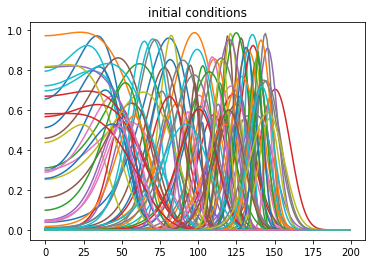

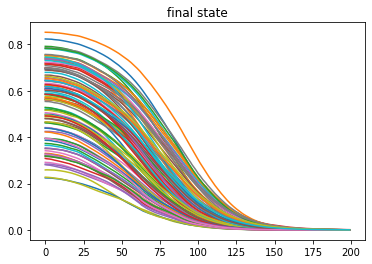

In [3]:
print('runs[0] shape: ', trajectories[0].shape)

for k in range(n_trajectories):
    plt.plot(trajectories[k][0])

plt.title('initial conditions')
plt.show()


for k in range(n_trajectories):
    plt.plot(trajectories[k][-1])

plt.title('final state')
plt.show()

In [4]:
sys.path.append("../experimental/")
import optimizers as eoptimizers

sys.path.append("../ELPH/")
import ELPH
system = ELPH.ELPH(kmax=2.0,n_kmax=200)


dim_reducer = derrom.dim_reducers.SVD()

# scaler = derrom.scalers.normalize_scaler(0.1)
scaler = derrom.scalers.standardize_scaler(1.0)

# transformer = derrom.transformers.polynomial_features(order=2)
transformer = derrom.transformers.ELM_features(ELM_nodes=400)

# optimizer = derrom.optimizers.ridge(alpha=10.**-3)
# optimizer = derrom.optimizers.lstsqrs()
optimizer = eoptimizers.PIML_adam(dim_reducer=dim_reducer,
                                  system=system,
                                  alpha=10.**-3.5, 
                                  lambda1=1e7, 
                                  mini_batch_size=39000, 
                                  epochs = 100)

model = derrom.derrom(trajectories, targets='AR', DE_l=2, intercept=True, full_hist=False,
                    optimizer=optimizer,
                    scaler=scaler,
                    dim_reducer=dim_reducer,
                    NL_transformer=transformer)

model.train(rdim=15)

model.print_status()

ridge regression loss: 58.572357
epoch: 1 loss: 390.43063
epoch: 2 loss: 488.34033
epoch: 3 loss: 318.9428
epoch: 4 loss: 340.3294
epoch: 5 loss: 99.39152
epoch: 6 loss: 269.3191
epoch: 7 loss: 260.9121
epoch: 8 loss: 144.06013
epoch: 9 loss: 180.7695
epoch: 10 loss: 151.42119
epoch: 11 loss: 90.030716
epoch: 12 loss: 152.89581
epoch: 13 loss: 180.01357
epoch: 14 loss: 107.26313
epoch: 15 loss: 89.6985
epoch: 16 loss: 122.09878
epoch: 17 loss: 102.66228
epoch: 18 loss: 84.15141
epoch: 19 loss: 104.13561
epoch: 20 loss: 94.57571
epoch: 21 loss: 70.33228
epoch: 22 loss: 88.55716
epoch: 23 loss: 102.41494
epoch: 24 loss: 78.96423
epoch: 25 loss: 70.086586
epoch: 26 loss: 79.80992
epoch: 27 loss: 73.090065
epoch: 28 loss: 70.10352
epoch: 29 loss: 79.747025
epoch: 30 loss: 72.325066
epoch: 31 loss: 61.476112
epoch: 32 loss: 69.23356
epoch: 33 loss: 71.920586
epoch: 34 loss: 64.7975
epoch: 35 loss: 66.63136
epoch: 36 loss: 67.30291
epoch: 37 loss: 62.55265
epoch: 38 loss: 65.65048
epoch: 39 

In [5]:

test_trajectory = derrom.utils.load_trajectories(filename='/home/agluedge/Preprints/ELPH/example_run.npz')[0].T
print('example trajectory loaded with shape: ', test_trajectory.shape)


example trajectory loaded with shape:  (400, 200)


In [6]:
test_trajectory = trajectories[17]

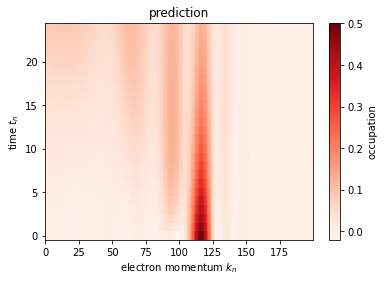

In [7]:
pred = model.forecast(test_trajectory[:1],25)

derrom.utils.plot_trajectory(pred,'prediction')

In [8]:
pred = model.predict(test_trajectory)

print('rms error: ', model.get_error(test_trajectory, pred=pred, norm='rms') )
print('max error: ', model.get_error(test_trajectory, pred=pred, norm='max') )

rms error:  0.0054565734811793665
max error:  0.03289707109717685


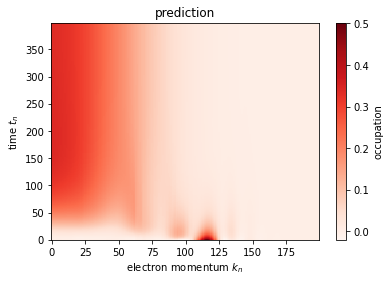

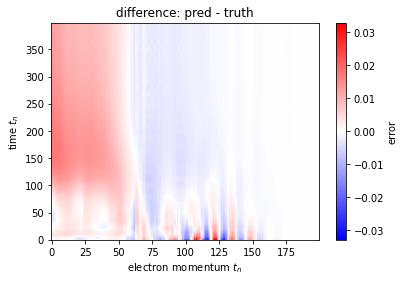

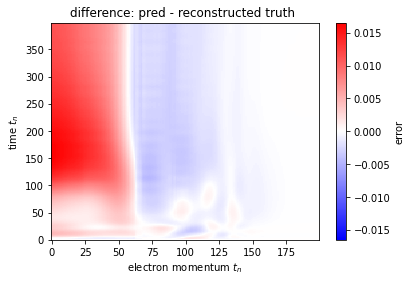

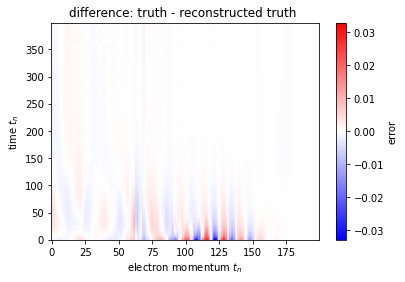

In [9]:

derrom.utils.plot_trajectory(pred, 'prediction')

derrom.utils.plot_difference(pred,test_trajectory,'difference: pred - truth')


test_trajectory_SVDapprx = dim_reducer.reconstruct( dim_reducer.reduce(test_trajectory,15) )

derrom.utils.plot_difference(pred,test_trajectory_SVDapprx,'difference: pred - reconstructed truth ')

derrom.utils.plot_difference(test_trajectory,test_trajectory_SVDapprx,'difference: truth - reconstructed truth ')

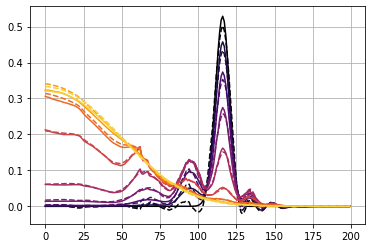

rms error:  0.0054565734811793665
max error:  0.03289707109717685


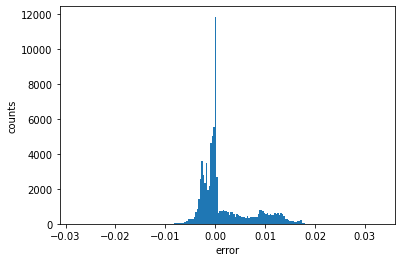

In [11]:
pl_colors = plt.get_cmap('inferno')

tn_arr = [0,2,5,10,20,50,100,200,399]

plt.grid()

for k,tn in enumerate(tn_arr):
    plt.plot(test_trajectory[tn], '-', c=pl_colors(k/len(tn_arr)))
    plt.plot(pred[tn], '--', c=pl_colors(k/len(tn_arr)))

plt.show()

print('rms error: ', model.get_error(test_trajectory, pred=pred, norm='rms') )
print('max error: ', model.get_error(test_trajectory, pred=pred, norm='max') )

plt.hist(np.ravel(pred-test_trajectory), bins = 200)
plt.xlabel('error')
plt.ylabel('counts')
plt.show()